# Toy example for the Metropolis MCMC algorithm

In this example, the Metropolis algorithm is used to sample the function fmodel.

To use the mcmc toolbox, one need to define three functions with the following signatures:

### The proposal

```python
def proposal(x, prop_S):
    """
    x : 1D numpy array 
        The vector containing the variables to sample
    
    prop_S : 1D numpy array
        A vector with the same shape as x containing the standard deviation for the proposal function

    xp : 1D numpy array 
        The proposed sample, same shape as x. It should be a small perturbation from the sample x.
    """
    ...
    return xp
```

In this scenario, the proposal is to perturb one element of x witha random number drawn from a gaussian distribution with 0 mean and standard deviation from prop_S.
    
### The (log) prior

```python
def logprior(x):
    ...
    return logp
```

Returns le log of the prior probability of sample x. In this scenario, the prior is uniform on [-4, 4]²


### The loglikelihood

```python
def loglikelihood(x):
    ...
    return loglike, predictions
```

The loglikelihood function is the Bayesian equivalent of the misfit function. From sample x, build a model and compute a replicate of the data observables. This replicate is compared to the data using a mahalanobis distance. This corresponds to a Gaussian model for the data distribution. Returns loglike (float) and predictions (dict).

    


In [1]:
# To replace packaging
# import sys
# sys.path.append("/home/nhedjazi/src/sealevel")

# Change to 
import os
import sys
#sys.path.insert(0, os.path.abspath('../../../sealevel'))
sys.path.insert(0, os.path.abspath('/Users/gino/Documents/SeaLevelHome/Pycharm'))

# Imports
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from mcmc.metropolis import Metropolis1dStep


ModuleNotFoundError: No module named 'arviz'

In [2]:
# The (unkown) function to sample from
def fmodel(a,b):
    x1 = (a-2.)/0.5
    y1 = b/2
    x2 = a/1.8
    y2 = (b-1.8)/0.7
    x3 = (a+1)/1.2
    y3 = (b+1)/0.6

    return 0.7*np.exp(-(x1**2+y1**2))+1.3*np.exp(-(x2**2+y2**2))+2.*np.exp(-(x3**2+y3**2))

The unkown here is a function of two variables a and b. We simply parametrize the space to sample as a vector x=(a,b). But we could use anything relating x to a and b, something more complex for example.

A sample of fmodel can be drawn by calling the function

In [3]:
# Example
x = (4,5)
fmodel(*x)


1.5989447201063809e-10

Let's see whats this function looks like

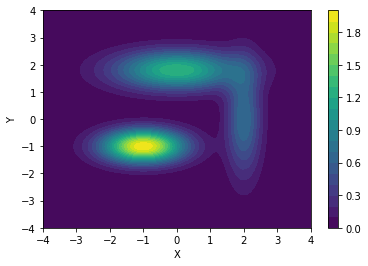

In [4]:
xx = np.linspace(-4, 4, 100)
yy = np.linspace(-4, 4, 100)
xx, yy = np.meshgrid(xx, yy)
zz = fmodel(xx, yy)
plt.figure()
plt.contourf(xx, yy, zz, 20)
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar()

In [5]:
# The proposal
def proposal(x, std):
    assert(x.size == std.size)
    xp = np.copy(x)
    # get the size of vector x
    n = x.size
    # Chose a random element in vector x
    i = np.random.randint(0, n)
    # Add a small perturbation
    dx = np.random.normal(0., std[i])
    xp[i] += dx
    return xp

In [6]:
# The log prior
# The prior 0 outside the bounds. Inside the bounds, it is 1/(domain size).
bounds = (-4, 4)

def prior(x):
    logprior = 0
    if any(x[i] < bounds[0] or x[i] > bounds[1] for i in range(x.size)):
        logprior = -np.inf  # log(0)
    else:
        # This is optional because it does not depend on x value, I put it for clarity
        for i in range(x.size):
            logprior += -np.log(bounds[1] - bounds[0])
    return logprior

bounds = np.array([[-2, 4],
                   [ -4, 4]])

def prior(x):
    logprior = 0
    n_params = len(x)
    for i in range(n_params):
        if (x[i] < bounds[i, 0] or x[i] > bounds[i, 1]):
            logprior = -np.inf  # log(0)
    else:
        # This is optional because it does not depend on x value, I put it for clarity
        for i in range(x.size):
            logprior += -np.log(bounds[i, 1] - bounds[i, 0])
    return logprior


            

In [7]:
# The loglikelihood
# In this toy example, we sample fmodel. In future applications, the loglikelihood is the negative of the misfit. 

# To compute the value of fmodel at a point x, as seen above, it is simply calling fmodel
def loglike(x):
    a, b = x[0], x[1]
    f = fmodel(a,b)
    return np.log(f), {"fmodel": f*np.ones((3, 3, 3))}


In [8]:
# def param(x):
#     load(file)
#     a = x[0]
#     b = x[1]
#     t[5]= a
#     e[5] = b
#     # interpolation
#     return xnew, ynew


# def misfit(x, y, x_obs, y_obs, sigma2):
#     y1 = align(x, y, x_obs)
#     n = len(y_obs)
#     vi = np.zeros((n,n))
#     for i in range(n):
#         vi[i, i] = 1/sigma2
#     fit = misfit.sqmahalanobis(y1, y_obs, vi)
#     return fit

# # option correlation
# def align(x, y, x_obs, y_obs):
#     # Expand to same x
#     w = scipy.signal.correlate(y, y_obs)
#     n = np.argmax(x)
#     # décaler y de n pas de x
#     # y1 = shifted(y)
#     # vérifier que y et y_obs ont la même taille
#     return y1
    
# def loglike(x):
#     x_obs, y_obs = load(file)
#     slope = ...
#     G0 = ....
#     t, e = param(x)
#     dbg = False
#     x, y, dz, xmin, xmax, ymin, ymax, x_ini, y_ini = reef(dbg, t, e, ...)
#     fit = misfit(x, y, x_obs, y_obs, sigma2)
#     return -0.5*fit
    

Now we have all the elements to build the MCMC algorithm

In [9]:
chain = Metropolis1dStep()
chain.proposal = proposal
chain.prop_S = np.array([2., 2.])
chain.logprior = prior
chain.loglikelihood = loglike
chain.show_stats = 10000

# Select a random starting point
da = bounds[0, 1] - bounds[0, 0]
db = bounds[1, 1] - bounds[1, 0]

print(da)
print(db)

a0 = bounds[0, 0] + np.random.rand()*da
b0 = bounds[1, 0] + np.random.rand()*db
x0 = np.array([a0, b0])

# Number of samples
n_samples = 20000
n_tune = 20000

# Record some statistics
chain.add_stat("loglikelihood")
chain.add_stat("accept_ratio")
chain.add_stat("prop_S")
chain.add_stat("parameter_accept_ratio")


NameError: name 'Metropolis1dStep' is not defined

In [10]:
# Run the algorithm

chain.run(x0, n_samples, tune=n_tune, tune_interval=100,
          discard_tuned_samples=False, thin=1)

print("Total duration:")
print(chain.duration)

Start Metropolis1dStep
----------------------
number of saved samples
None

---------------------------------
        -- MCMC stats --         
---------------------------------
At sample number 10000
loglikelihood
[-0.32827181]
accept_ratio
[0.37853785]
prop_S
[2.898918 2.3958  ]
parameter_accept_ratio
[0.51162791 0.31578947]


---------------------------------
        -- MCMC stats --         
---------------------------------
At sample number 20000
loglikelihood
[-1.01505153]
accept_ratio
[0.37086854]
prop_S
[3.43788773 2.78468906]
parameter_accept_ratio
[0.32727273 0.26666667]

Total duration:
0:00:03.631126


## Plotting

Here are some first examples of things to plot:

- "trace plots" : its a line plot showing the evolution of a certain quantity during the iterations. It is used mainly to check the convergence of the chain

- "posterior distribution" : this is the main result of the algorithm. Easy to plot here in 2D, more difficult to visualize in higher dimensions

- "marginals" : the marginal distribution of a variable is its 1D distribution, that is summed over all the other possible values for the other variables.

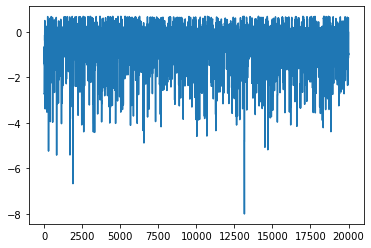

In [11]:
# Some trace plots
plt.figure()
plt.plot(chain.stats["loglikelihood"])

Text(0, 0.5, 'Y')

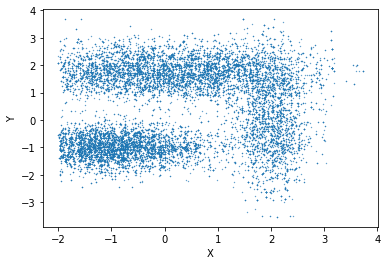

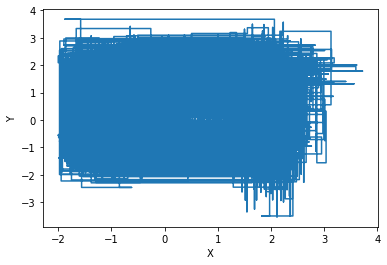

In [12]:
# Plot the posterior samples
plt.figure()
plt.scatter(chain.samples[:, 0], chain.samples[:, 1], s=0.1)
plt.xlabel('X')
plt.ylabel('Y')

plt.figure()
plt.plot(chain.samples[:, 0], chain.samples[:, 1])
plt.xlabel('X')
plt.ylabel('Y')

Text(0, 0.5, 'Y')

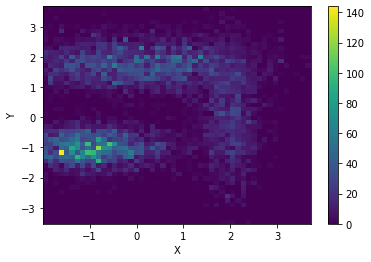

In [13]:
# Same plot as a 2D histogram
plt.figure()
h = plt.hist2d(chain.samples[:, 0], chain.samples[:, 1], bins=(50,50))
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')

Text(0.5, 0, 'Y')

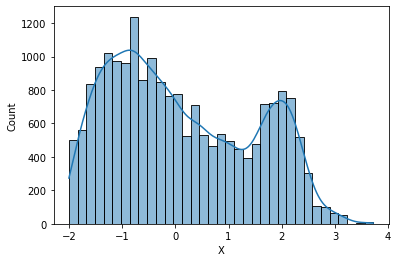

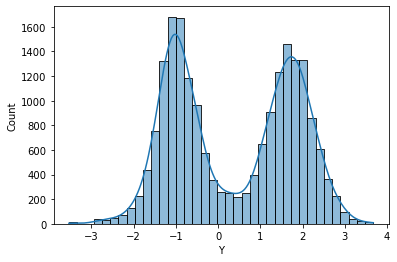

In [14]:
# Marginals are 1D histograms
# 1) for X
plt.figure()
sns.histplot(chain.samples[:, 0], kde=True)
plt.xlabel('X')

# 2) for Y
plt.figure()
sns.histplot(chain.samples[:, 1], kde=True)
plt.xlabel('Y')

### Test linking with arviz for visualization

In [15]:
import arviz
# Transform results to a arviz dataset
dataset = chain.get_results(format='arviz')

# Test read/write to netCDF format
# Save it
dataset.to_netcdf("test_results_arviz.nc")
# Load it again
dataset = arviz.from_netcdf("test_results_arviz.nc")

# New function to write results
chain.write_samples("test_results_arviz.nc", format='arviz')
# Load it again
dataset = arviz.from_netcdf("test_results_arviz.nc")

### Some plots examples

array([[<AxesSubplot:title={'center':'x\n0'}>,
        <AxesSubplot:title={'center':'x\n0'}>],
       [<AxesSubplot:title={'center':'x\n1'}>,
        <AxesSubplot:title={'center':'x\n1'}>]], dtype=object)

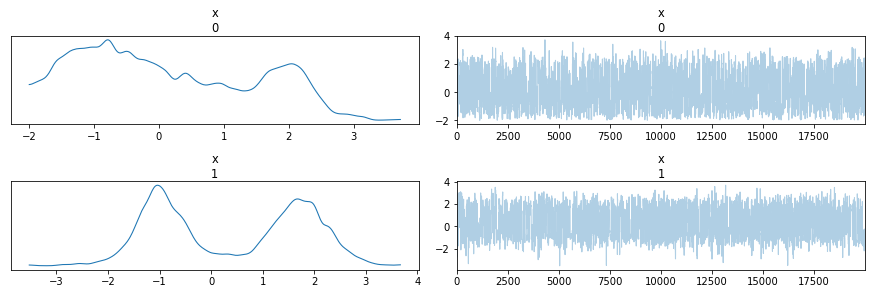

In [16]:
# Trace plots
arviz.plot_trace(dataset)

array([[<AxesSubplot:title={'center':'log_likelihood\n0'}>]], dtype=object)

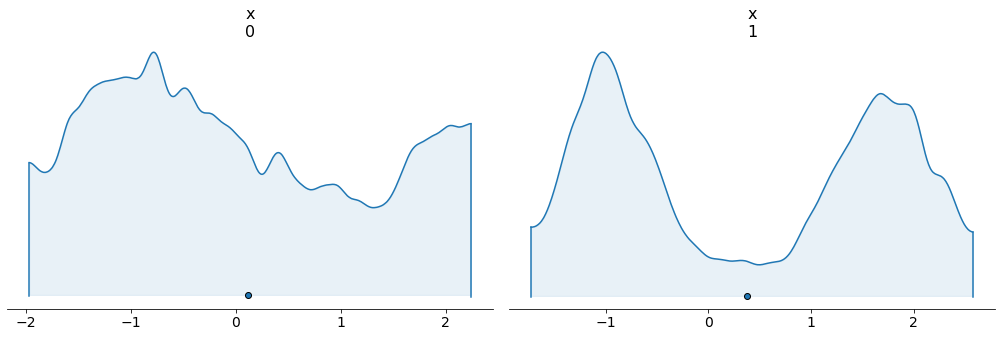

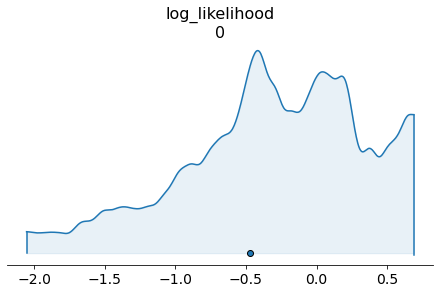

In [17]:
# Density plots for the posterior
arviz.plot_density(dataset,
    var_names=["x"],
    shade=0.1,)

# Loglikelihood density
arviz.plot_density(dataset,
    group="log_likelihood",
    shade=0.1,)

array([<AxesSubplot:title={'center':'x\n0, 0'}>,
       <AxesSubplot:title={'center':'x\n0, 1'}>], dtype=object)

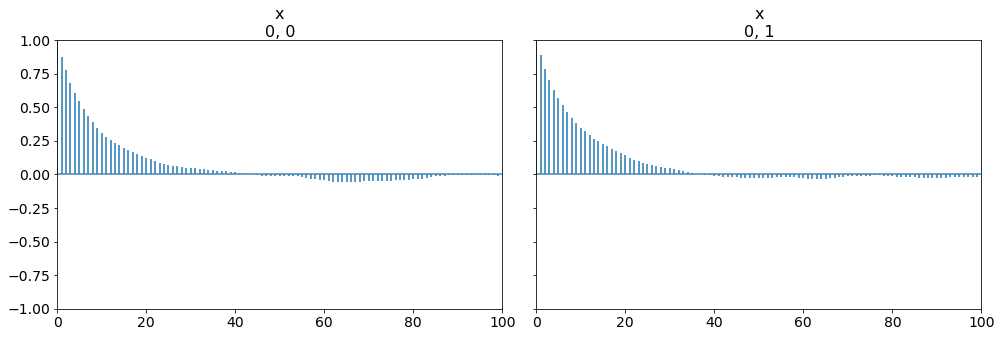

In [18]:
# Autocorrelation plot
arviz.plot_autocorr(dataset, var_names=("x"))

<AxesSubplot:>

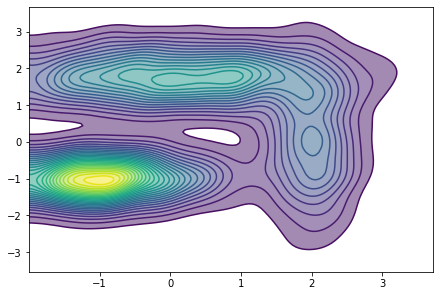

In [19]:
# 2D density plot
arviz.plot_kde(
    dataset.posterior.x.values[0, :, 0],
    dataset.posterior.x.values[0, :, 1],
    contour_kwargs={"colors": None, "cmap": plt.cm.viridis, "levels": 30},
    contourf_kwargs={"alpha": 0.5, "levels": 30},
)

### Arviz data structure

You can see arviz data structure below

In [20]:
dataset.posterior

<xarray.Dataset>
Dimensions:  (chain: 1, draw: 20000, x_dim_0: 2)
Coordinates:
  * chain    (chain) int64 0
  * draw     (draw) int64 0 1 2 3 4 5 6 ... 19994 19995 19996 19997 19998 19999
  * x_dim_0  (x_dim_0) int64 0 1
Data variables:
    x        (chain, draw, x_dim_0) float64 2.342 -2.754 2.342 ... -0.55 -0.5459
Attributes:
    created_at:     2021-01-27T20:32:02.117224
    arviz_version:  0.10.0

In [21]:
dataset.log_likelihood

<xarray.Dataset>
Dimensions:               (chain: 1, draw: 20000, log_likelihood_dim_0: 1)
Coordinates:
  * chain                 (chain) int64 0
  * draw                  (draw) int64 0 1 2 3 4 ... 19996 19997 19998 19999
  * log_likelihood_dim_0  (log_likelihood_dim_0) int64 0
Data variables:
    log_likelihood        (chain, draw, log_likelihood_dim_0) float64 ...
Attributes:
    created_at:     2021-01-27T20:32:02.121098
    arviz_version:  0.10.0

In [22]:
dataset.sample_stats

<xarray.Dataset>
Dimensions:                       (accept_ratio_dim_0: 1, chain: 1, draw: 20000, parameter_accept_ratio_dim_0: 2, prop_S_dim_0: 2)
Coordinates:
  * chain                         (chain) int64 0
  * draw                          (draw) int64 0 1 2 3 ... 19997 19998 19999
  * accept_ratio_dim_0            (accept_ratio_dim_0) int64 0
  * prop_S_dim_0                  (prop_S_dim_0) int64 0 1
  * parameter_accept_ratio_dim_0  (parameter_accept_ratio_dim_0) int64 0 1
Data variables:
    accept_ratio                  (chain, draw, accept_ratio_dim_0) float64 ...
    prop_S                        (chain, draw, prop_S_dim_0) float64 ...
    parameter_accept_ratio        (chain, draw, parameter_accept_ratio_dim_0) float64 ...
Attributes:
    created_at:     2021-01-27T20:32:02.118618
    arviz_version:  0.10.0

In [23]:
# For example see the array in prop_S
dataset.sample_stats.prop_S

<xarray.DataArray 'prop_S' (chain: 1, draw: 20000, prop_S_dim_0: 2)>
array([[[2.      , 2.      ],
        [2.      , 2.      ],
        ...,
        [3.437888, 2.784689],
        [3.437888, 2.784689]]])
Coordinates:
  * chain         (chain) int64 0
  * draw          (draw) int64 0 1 2 3 4 5 ... 19995 19996 19997 19998 19999
  * prop_S_dim_0  (prop_S_dim_0) int64 0 1

In [24]:
dataset.posterior_predictive

<xarray.Dataset>
Dimensions:       (chain: 1, draw: 20000, fmodel_dim_0: 3, fmodel_dim_1: 3, fmodel_dim_2: 3)
Coordinates:
  * chain         (chain) int64 0
  * draw          (draw) int64 0 1 2 3 4 5 ... 19995 19996 19997 19998 19999
  * fmodel_dim_0  (fmodel_dim_0) int64 0 1 2
  * fmodel_dim_1  (fmodel_dim_1) int64 0 1 2
  * fmodel_dim_2  (fmodel_dim_2) int64 0 1 2
Data variables:
    fmodel        (chain, draw, fmodel_dim_0, fmodel_dim_1, fmodel_dim_2) float64 ...
Attributes:
    created_at:     2021-01-27T20:32:02.122032
    arviz_version:  0.10.0

### Plot of some of the saved statistic

accept ratio, global and per parameter

proposal standard deviation

Text(0, 0.5, 'Proposal std')

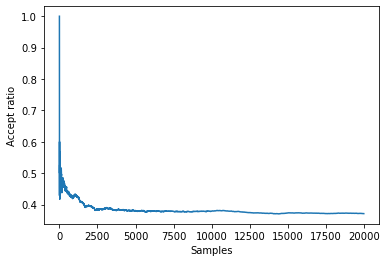

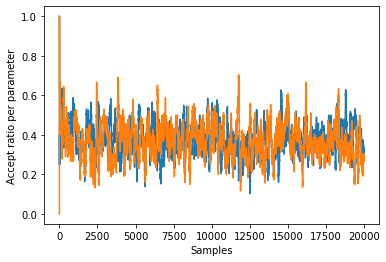

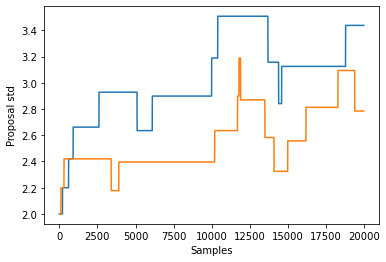

In [25]:
# Some trace plots
plt.figure()
plt.plot(dataset.sample_stats.accept_ratio[0, :, 0])
plt.xlabel('Samples')
plt.ylabel('Accept ratio')

plt.figure()
plt.plot(dataset.sample_stats.parameter_accept_ratio[0, :, 0])
plt.plot(dataset.sample_stats.parameter_accept_ratio[0, :, 1])
plt.xlabel('Samples')
plt.ylabel('Accept ratio per parameter')
                                                     
plt.figure()
plt.plot(dataset.sample_stats.prop_S[0, :, 0])
plt.plot(dataset.sample_stats.prop_S[0, :, 1])
plt.xlabel('Samples')
plt.ylabel('Proposal std')